In [2]:
import numpy as np
import pandas as pd
import datetime
import random
random.seed(10)

In [5]:
df = pd.read_csv('../Data/Dummy_data_1week_7Dec.csv')
df = df.set_index(['lat_grid','long_grid'])

In [12]:
def data_preparation(datafile):
    lat_range = {'min': 28.486, 'max': 28.72}
    long_range = {'min': 77.1, 'max': 77.32}
    n_lat_grid = 25
    n_long_grid = 25
    
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @180min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    #taking only data from 6Am-12midnight
    df = df[(df.dateTime>=360)] 
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    df = df.fillna(0)
    return df

# ARIMA for one grid location

In [62]:
df_temp = df.loc[0, 22].reset_index()
df_temp.columns = [['time', 'pm2_5']]
df_pm = df_temp['pm2_5']
df_pm.head()

,pm2_5
0,274.869242
1,275.605369
2,185.320702
3,142.292380
4,210.565693


In [63]:
df_pm['PM First Difference'] = df_pm['pm2_5'] - df_pm['pm2_5'].shift(1)
df_pm['Seasonal First Difference']=df_pm['pm2_5']-df_pm['pm2_5'].shift(6)
# df_pm.head()

<AxesSubplot:>

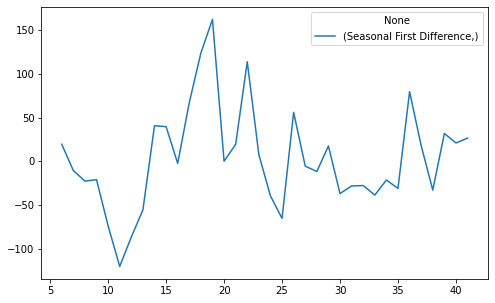

In [64]:
df_pm['Seasonal First Difference'].plot()

<AxesSubplot:>

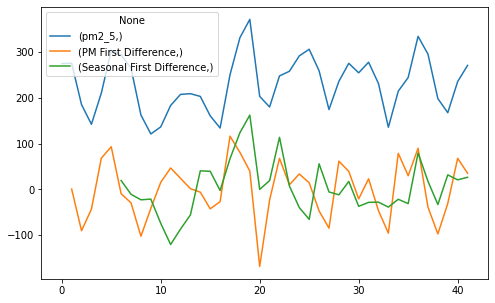

In [65]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
df_pm.plot()

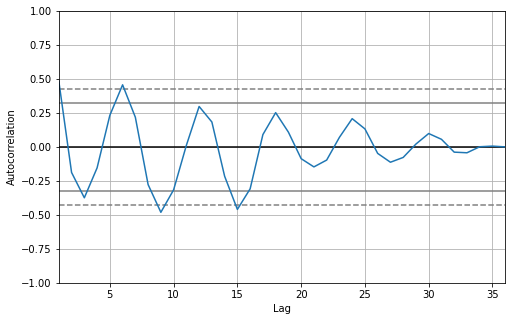

In [66]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_pm['pm2_5'][:36])
plt.show()

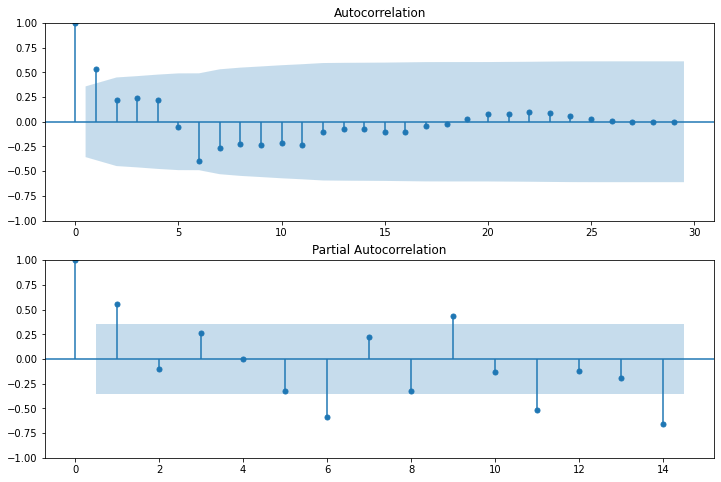

In [67]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_pm['Seasonal First Difference'][:36].dropna(),lags=29,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_pm['Seasonal First Difference'][:36].dropna(),lags=14,ax=ax2)

In [69]:
#first 6 days as training data 
from statsmodels.tsa.arima.model import ARIMA
# model = ARIMA(df_pm['pm2_5'][:39], order=(6,1,1))
model = ARIMA(df_pm['pm2_5'][:36], order=(5,1,1))
# model = ARIMA(df_pm, order=(1,1,1))

In [70]:
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  pm2_5   No. Observations:                   36
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -181.893
Date:                Mon, 13 Jun 2022   AIC                            377.785
Time:                        21:57:54   BIC                            388.673
Sample:                             0   HQIC                           381.544
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3886      0.733     -0.530      0.596      -1.826       1.049
ar.L2         -0.6832      0.152     -4.488      0.000      -0.982      -0.385
ar.L3         -0.5507      0.491     -1.120      0.263      -1.514       0.413
ar.L4         -0.5264      0.271     -1.945      0.052      -1.057       0.004
ar.L5         -0.3777      0.393     -0.962      0.336      -1.147       0.392
ma.L1          0.1875      0.769      0.244      0.807      -1.319       1.694
sigma2      1796.4755    588.082      3.055      0.002     643.856    2949.095
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.93   Prob(JB):                         0.58
Heteroskedasticity (H):               0.74   Skew:                             0.40
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

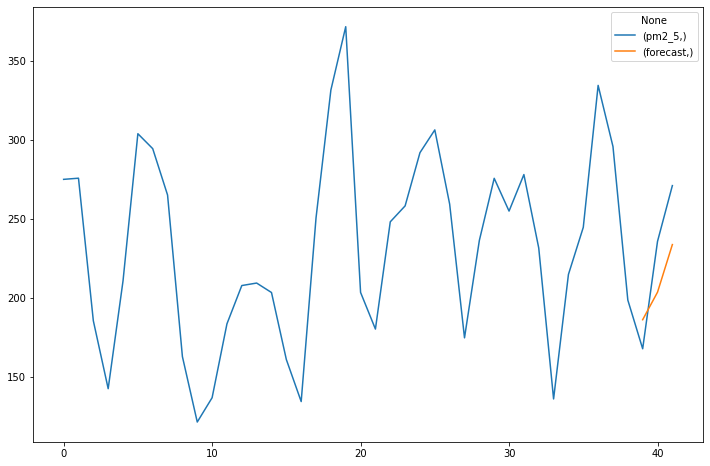

In [71]:
df_pm['forecast']=model_fit.predict(start=39,end=42,dynamic=True)
df_pm[['pm2_5','forecast']].plot(figsize=(12,8))

In [72]:
# import statsmodels.api as sm
# model=sm.tsa.statespace.SARIMAX(df_pm['pm2_5'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
# results=model.fit()
# df_pm['forecast']=results.predict(start=35,end=55,dynamic=True)
# df_pm[['pm2_5','forecast']].plot(figsize=(12,8))

In [73]:
# df_pm

In [74]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
sqrt(mean_squared_error(df_pm['pm2_5'][-3:], df_pm['forecast'][-3:]))

30.37943048740927

# ARIMA Baseline

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [16]:
days = ['7Jan', '10Jan', '15Dec', '7Dec', '24Jan', '15Nov', '28Nov', '20Nov']
filename = ['../Data/Dummy_data_1week_'+ day +'.csv' for day in days]

In [17]:
# df = pd.read_csv('../Data/Dummy_data_1week_7Jan.csv')
# df = df.set_index(['lat_grid','long_grid'])

In [19]:
test_rmse = []
for file in filename:
    df = pd.read_csv(file)
    df = df.set_index(['lat_grid','long_grid'])
    train_size = 36
    actual_test, predicted_test = pd.DataFrame(), pd.DataFrame()
    for i, row in df.iterrows():
        df_row = row.to_frame().reset_index()
        df_row.columns = [['time', 'pm2_5']]
        model = ARIMA(df_row['pm2_5'][:train_size], order=(3,1,1))
        model_fit=model.fit()
        df_row['forecast']=model_fit.predict(start=train_size,end=42,dynamic=True)
        # df_row[['pm2_5','forecast']].plot(figsize=(12,8))
        actual_row = df_row['pm2_5'][train_size:]
        predicted_row = df_row['forecast'][train_size:]
        actual_test = actual_test.append(actual_row)
        predicted_test = predicted_test.append(predicted_row)
    actual_test = np.array(actual_test)
    predicted_test = np.array(predicted_test)
    rmse = sqrt(mean_squared_error(actual_test[actual_test>0], predicted_test[actual_test>0]))
    print(rmse)
    test_rmse.append(rmse)

51.714437172943875
48.71952912166273
68.04400211855263
119.98611584422818
73.50990043179395
114.7075444114756
78.41504939870646
101.58869000923784


In [21]:
out = pd.DataFrame()
out['rmse'] = test_rmse
out['day'] = days
out.to_csv('arima_results.csv')

In [22]:
out['rmse'].mean()

82.08565856357515